In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from pysal.lib import weights
from libpysal.io import open as psopen
# import plots
import seaborn as sns
from datetime import datetime, timedelta
import jenkspy
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
warnings.filterwarnings("ignore")


In [102]:
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/research/RECAST/latin-mobility-covid-local-files'

country = 'Colombia'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'

In [103]:
category = 'rdi'



In [104]:
# df = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_outflows_param_tidy_results_o_new.csv')
# df_m3_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m3o_re_new.csv')
# df_m4_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m4o_re_new.csv')
# df_m5_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m5o_re_new.csv')
# df_m6_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m6o_re_new.csv')
# df_m7_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m7o_re_new.csv')

df = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_outflows_param_tidy_results_os_new.csv')
df_m3_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m3os_re_new.csv')
df_m4_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m4os_re_new.csv')
df_m5_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m5os_re_new.csv')
df_m6_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m6os_re_new.csv')
df_m7_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m7os_re_new.csv')


In [105]:
model = 6

df_model = df[df['model']==model].reset_index(drop=True)

fe_intercept = df_model[df_model['term'].str.contains('Intercept')]['estimate'].reset_index(drop=True).loc[0]
if model == 6:
    re_intercept = df_m6_re[df_m6_re['facet'].str.contains('Intercept')].reset_index(drop=True)
    intercept = list([fe_intercept + re_intercept['estimate'].loc[i] for i in range(len(np.unique(df_m6_re['term'])))])
elif model == 5:
    re_intercept = df_m5_re[df_m5_re['facet'].str.contains('Intercept')].reset_index(drop=True)
    intercept = list([fe_intercept + re_intercept['estimate'].loc[i] for i in range(len(np.unique(df_m5_re['term'])))])


fe_slope = df_model[df_model['term']=='time']['estimate'].reset_index(drop=True).loc[0]

if model == 6:
    re_slope = df_m6_re[df_m6_re['facet']=='time'].reset_index(drop=True)
    slope = list([fe_slope + re_slope['estimate'].loc[i] for i in range(len(np.unique(df_m6_re['term'])))])
elif model == 5:
    re_slope = df_m5_re[df_m5_re['facet']=='time'].reset_index(drop=True)
    slope = list([fe_slope + re_slope['estimate'].loc[i] for i in range(len(np.unique(df_m5_re['term'])))])

try:
    stringency = [df_model[df_model['term']=='stringency_index']['estimate'].reset_index(drop=True).loc[0]
                  for i in range(len(intercept))]
except:
    stringency = [0 for i in range(len(intercept))]

slope = [slope[i] + stringency[i] for i in range(len(slope))]

if model == 6:
    quad = [df_model[df_model['term']=='time2']['estimate'].reset_index(drop=True).loc[0]
                  for i in range(len(intercept))]

In [106]:
fe_intercept_std = df_model[df_model['term'].str.contains('Intercept')]['std.error'].reset_index(drop=True).loc[0]
if model == 6:
    re_intercept = df_m6_re[df_m6_re['facet'].str.contains('Intercept')].reset_index(drop=True)
elif model == 5:
    re_intercept = df_m5_re[df_m5_re['facet'].str.contains('Intercept')].reset_index(drop=True)
re_intercept_ci = [re_intercept.loc[i, 'conf.high'] - re_intercept.loc[i, 'conf.low'] for i in range(len(re_intercept))]
# assuming gaussian distribution
re_intercept_std = [ci/(2*1.96) for ci in re_intercept_ci]
# intercept_std = [np.sqrt(fe_intercept_std**2 + std**2) for std in re_intercept_std]
intercept_std = [np.sqrt(fe_intercept_std**2) for std in re_intercept_std]
    

fe_time_std = df_model[df_model['term']=='time']['std.error'].reset_index(drop=True).loc[0]
try:
    fe_stringency_std = df_model[df_model['term']=='stringency_index']['std.error'].reset_index(drop=True).loc[0]
except:
    fe_stringency_std = 0
if model == 6:
    re_time = df_m6_re[df_m6_re['facet'].str.contains('time')].reset_index(drop=True)
elif model == 5:
    re_time = df_m5_re[df_m5_re['facet'].str.contains('time')].reset_index(drop=True)
re_time_ci = [re_time.loc[i, 'conf.high'] - re_time.loc[i, 'conf.low'] for i in range(len(re_time))]
# assuming gaussian distribution
re_time_std = [ci/(2*1.96) for ci in re_time_ci]
# slope_std = [np.sqrt(fe_time_std**2 + fe_stringency_std**2 + std**2) for std in re_time_std]
slope_std = [np.sqrt(fe_time_std**2 + fe_stringency_std**2) for std in re_time_std]

if model == 6:
    fe_quad_std = df_model[df_model['term']=='time2']['std.error'].reset_index(drop=True).loc[0]
if model == 5:
    fe_quad_std = 0
quad_std = [fe_quad_std for i in range(len(slope_std))]

In [107]:
thresholds = np.arange(1,100)
times = []
times_std = []

for thr in thresholds:
    
    times_thr = []
    times_thr_std = []
    for i in range(len(intercept)):
        if intercept[i]>0 and slope[i]>0:
            times_thr.append(-1)
        else:    
            if model == 6:
                time_thr = (-slope[i]+np.sqrt(slope[i]**2-4*quad[i]*(thr/100)*intercept[i]))/(2*quad[i])
                if slope[i]**2-4*quad[i]*(thr/100)*intercept[i] >= 0:
                    if time_thr > 0:
                        times_thr.append(time_thr)
                        partial_intercept = (-(thr/100))/(np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i]))
                        partial_slope = (1/quad[i])*(-1+(slope[i])/(np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i])))
                        partial_quad = (-(thr/100)*intercept[i])/(quad[i]*np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i])) + (slope[i] - np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i]))/(2*quad[i]**2)
                    else:
                        time_thr = (-slope[i]-np.sqrt(slope[i]**2-4*quad[i]*(thr/100)*intercept[i]))/(2*quad[i])
                        times_thr.append(time_thr)
                        partial_intercept = (thr/100)/(np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i]))
                        partial_slope = (1/quad[i])*(-1-(slope[i])/(np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i])))
                        partial_quad = ((thr/100)*intercept[i])/(quad[i]*np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i])) + (slope[i] + np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i]))/(2*quad[i]**2)
                    time_thr_std = np.sqrt((partial_intercept*intercept_std[i])**2 +
                                            (partial_slope*slope_std[i])**2 +
                                            (partial_quad*quad_std[i])**2)
                    times_thr_std.append(time_thr_std)
                else: 
                    times_thr.append(np.nan)
                    times_thr_std.append(np.nan)
                    
            elif model == 5:
                time_thr = - (thr/100)*(intercept[i]/slope[i])
                times_thr.append(time_thr) 
                partial_intercept = -(thr/100)/slope[i]
                partial_slope = ((thr/100)*intercept[i])/(slope[i]**2)
                time_thr_std = np.sqrt((partial_intercept*intercept_std[i])**2 +
                                           (partial_slope*slope_std[i])**2)
                times_thr_std.append(time_thr_std)
                
    times.append(times_thr)
    times_std.append(times_thr_std)
    
        

times = np.array(times).T
times_std = np.array(times_std).T

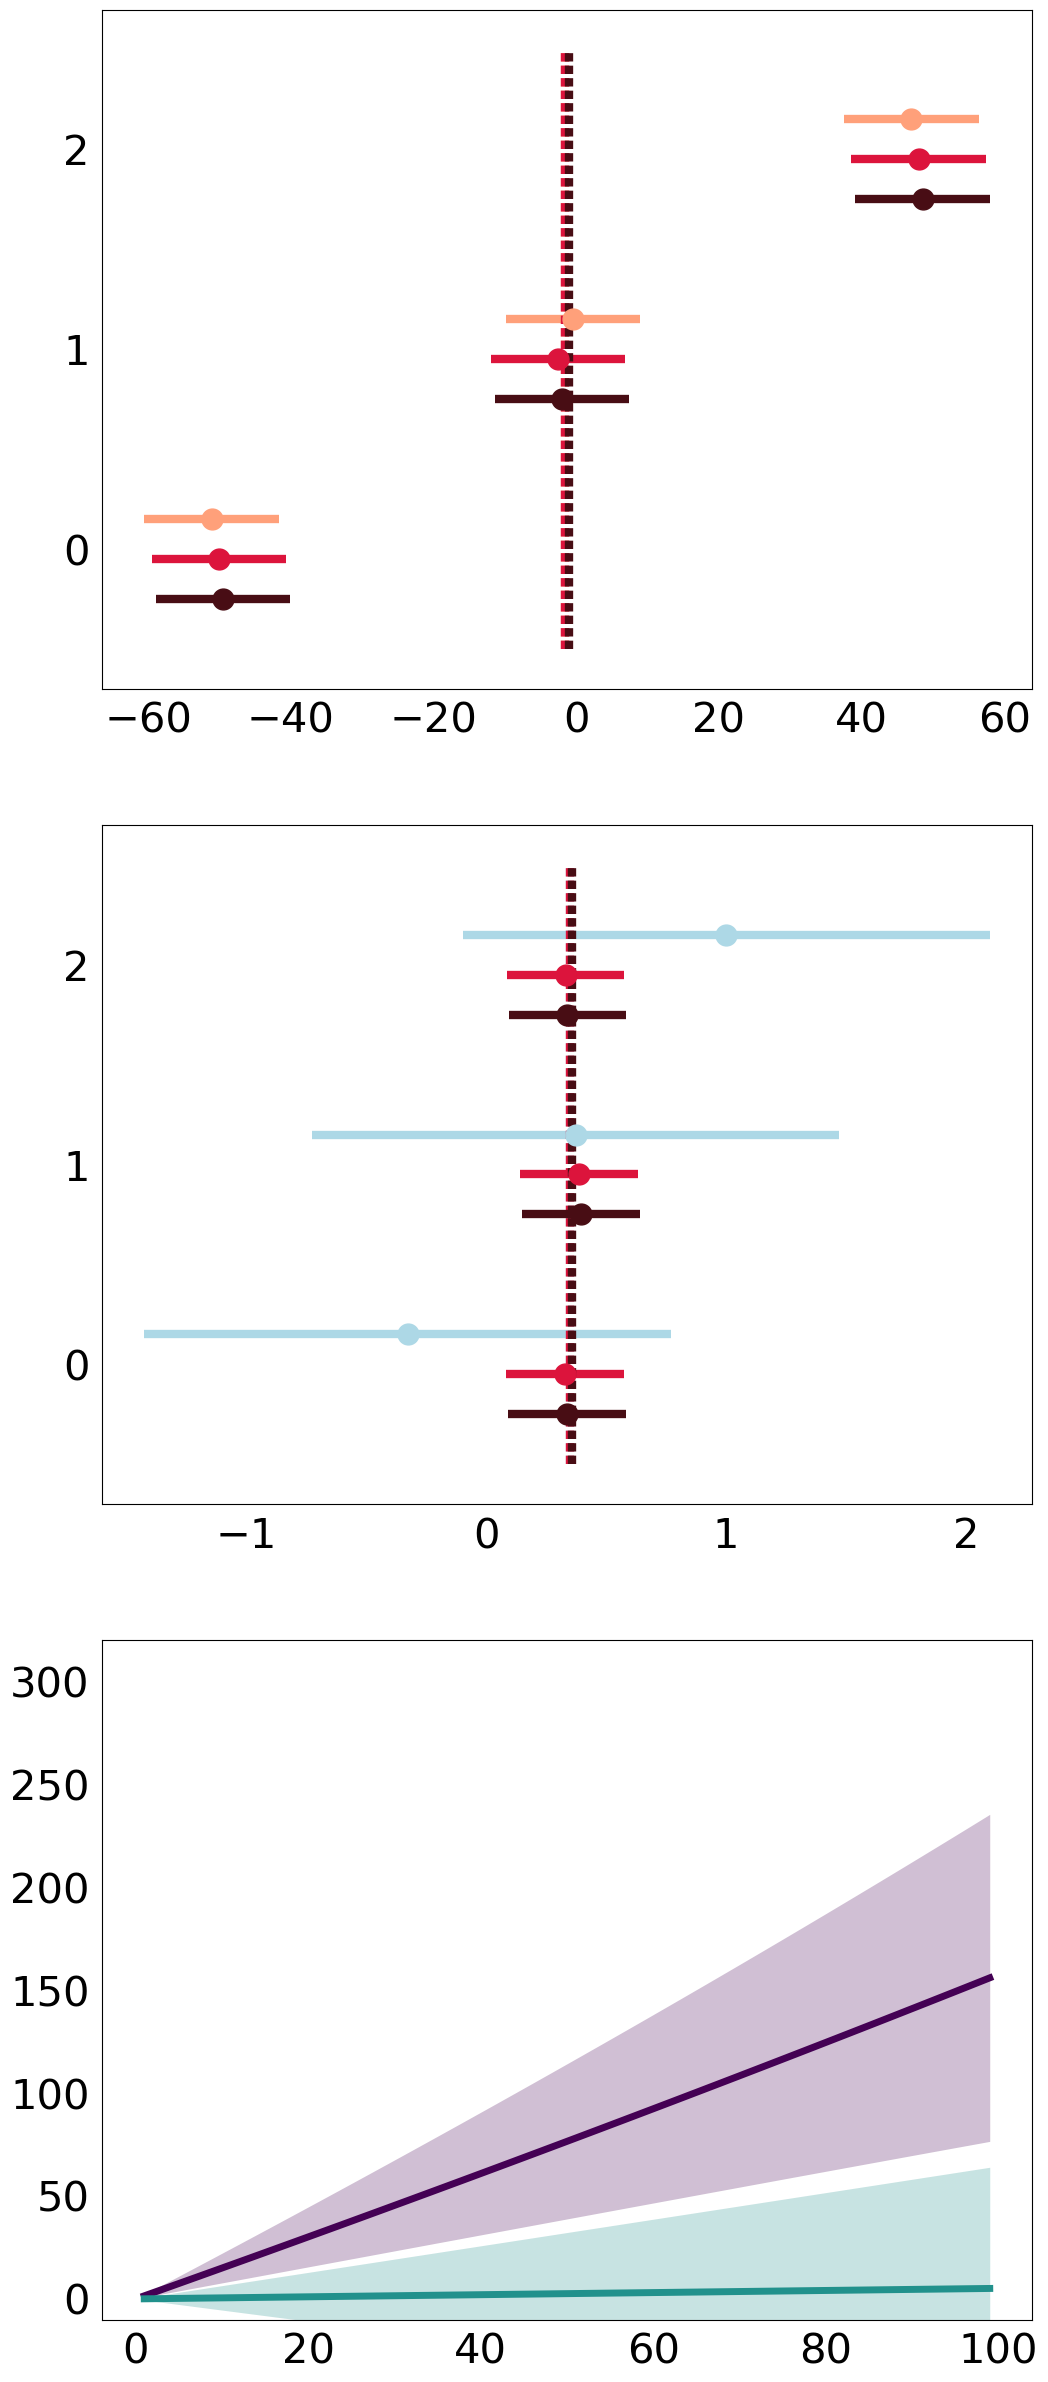

In [108]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(12,30))

ax1.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=30, pad=9)

left_error = df_m3_re['estimate'] - df_m3_re['conf.low'] 
right_error = df_m3_re['conf.high'] - df_m3_re['estimate'] 
estimate = df[(df['model']==3) & (df['term']=='(Intercept)')]['estimate'].reset_index(drop=True)
ax1.errorbar(df_m3_re['estimate'] + estimate.loc[0], list(df_m3_re.index+0.15), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15, color='lightsalmon')
ax1.plot([estimate, estimate], [min(list(df_m3_re.index))-.5, max(list(df_m3_re.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color='lightsalmon')

df_m5_re_intercept = df_m5_re[df_m5_re['facet'].str.contains('Intercept')].reset_index(drop=True)
left_error = df_m5_re_intercept['estimate'] - df_m5_re_intercept['conf.low'] 
right_error = df_m5_re_intercept['conf.high'] - df_m5_re_intercept['estimate'] 
estimate = df[(df['model']==5) & (df['term']=='(Intercept)')]['estimate'].reset_index(drop=True)
ax1.errorbar(df_m5_re_intercept['estimate'] + estimate.loc[0], list(df_m5_re_intercept.index-0.05), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15,  color='crimson')
ax1.plot([estimate, estimate], [min(list(df_m5_re_intercept.index))-.5, max(list(df_m5_re_intercept.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color='crimson')

df_m6_re_intercept = df_m6_re[df_m6_re['facet'].str.contains('Intercept')].reset_index(drop=True)
left_error = df_m6_re_intercept['estimate'] - df_m6_re_intercept['conf.low'] 
right_error = df_m6_re_intercept['conf.high'] - df_m6_re_intercept['estimate'] 
estimate = df[(df['model']==6) & (df['term']=='(Intercept)')]['estimate'].reset_index(drop=True)
ax1.errorbar(df_m6_re_intercept['estimate'] + estimate.loc[0], list(df_m6_re_intercept.index-0.25), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15,  color=(72/255, 13/255, 20/255))
ax1.plot([estimate, estimate], [min(list(df_m6_re_intercept.index))-.5, max(list(df_m6_re_intercept.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color=(72/255, 13/255, 20/255))

# df_m7_re_intercept = df_m7_re[df_m7_re['facet'].str.contains('Intercept')].reset_index(drop=True)
# left_error = df_m7_re_intercept['estimate'] - df_m7_re_intercept['conf.low'] 
# right_error = df_m7_re_intercept['conf.high'] - df_m7_re_intercept['estimate'] 
# estimate = df[(df['model']==7) & (df['term']=='(Intercept)')]['estimate'].reset_index(drop=True)
# ax1.errorbar(df_m7_re_intercept['estimate'] + estimate.loc[0], list(df_m7_re_intercept.index-0.45), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15,  color=(72/255, 13/255, 20/255))
# ax1.plot([estimate, estimate], [min(list(df_m7_re_intercept.index))-.5, max(list(df_m7_re_intercept.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color=(72/255, 13/255, 20/255))

ax1.set_ylim(min(list(df_m5_re_intercept.index))-0.7, max(list(df_m5_re_intercept.index))+0.7)
ax1.set_yticks(list(df_m5_re_intercept.index), list(df_m5_re_intercept.index))

ax2.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=30, pad=9)

left_error = df_m4_re['estimate'] - df_m4_re['conf.low'] 
right_error = df_m4_re['conf.high'] - df_m4_re['estimate'] 
estimate = df[(df['model']==2) & (df['term']=='time')]['estimate'].reset_index(drop=True)
ax2.errorbar(df_m4_re['estimate'] + estimate.loc[0], list(df_m4_re.index+0.15), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15, color='lightblue')
ax2.plot([estimate, estimate], [min(list(df_m4_re.index))-.5, max(list(df_m4_re.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color='lightblue')

df_m5_re_slope = df_m5_re[df_m5_re['facet']=='time'].reset_index(drop=True)
left_error = df_m5_re_slope['estimate'] - df_m5_re_slope['conf.low'] 
right_error = df_m5_re_slope['conf.high'] - df_m5_re_slope['estimate'] 
estimate = df[(df['model']==5) & (df['term']=='time')]['estimate'].reset_index(drop=True)
ax2.errorbar(df_m5_re_slope['estimate'] + estimate.loc[0], list(df_m5_re_slope.index-0.05), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15, color='crimson')
ax2.plot([estimate, estimate], [min(list(df_m5_re_slope.index))-.5, max(list(df_m5_re_slope.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color='crimson')

df_m6_re_slope = df_m6_re[df_m6_re['facet']=='time'].reset_index(drop=True)
left_error = df_m6_re_slope['estimate'] - df_m6_re_slope['conf.low'] 
right_error = df_m6_re_slope['conf.high'] - df_m6_re_slope['estimate'] 
estimate = df[(df['model']==6) & (df['term']=='time')]['estimate'].reset_index(drop=True)
ax2.errorbar(df_m6_re_slope['estimate'] + estimate.loc[0], list(df_m6_re_slope.index-0.25), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15, color=(72/255, 13/255, 20/255))
ax2.plot([estimate, estimate], [min(list(df_m6_re_slope.index))-.5, max(list(df_m6_re_slope.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color=(72/255, 13/255, 20/255))

# df_m7_re_slope = df_m7_re[df_m7_re['facet']=='time'].reset_index(drop=True)
# left_error = df_m7_re_slope['estimate'] - df_m7_re_slope['conf.low'] 
# right_error = df_m7_re_slope['conf.high'] - df_m7_re_slope['estimate'] 
# estimate = df[(df['model']==7) & (df['term']=='time')]['estimate'].reset_index(drop=True)
# ax2.errorbar(df_m7_re_slope['estimate'] + estimate.loc[0], list(df_m7_re_slope.index-0.45), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15, color=(72/255, 13/255, 20/255))
# ax2.plot([estimate, estimate], [min(list(df_m7_re_slope.index))-.5, max(list(df_m7_re_slope.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color=(72/255, 13/255, 20/255))

ax2.set_ylim(min(list(df_m5_re_intercept.index))-0.7, max(list(df_m5_re_intercept.index))+0.7)
ax2.set_yticks(list(df_m5_re_slope.index), list(df_m5_re_slope.index))


ax3.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=30, pad=9)

# df_m7_re_quad = df_m7_re[df_m7_re['facet']=='time2'].reset_index(drop=True)
# left_error = df_m7_re_quad['estimate'] - df_m7_re_quad['conf.low'] 
# right_error = df_m7_re_quad['conf.high'] - df_m7_re_quad['estimate'] 
# estimate = df[(df['model']==7) & (df['term']=='time2')]['estimate'].reset_index(drop=True)
# ax3.errorbar(df_m7_re_quad['estimate'] + estimate.loc[0], list(df_m7_re_quad.index), xerr=[left_error, right_error], fmt='o', linewidth=6, markersize=15, color=(72/255, 13/255, 20/255) )
# ax3.plot([estimate, estimate], [min(list(df_m7_re_quad.index))-.5, max(list(df_m7_re_quad.index))+.5], linestyle=':', dashes=(1,.5), linewidth=6, color=(72/255, 13/255, 20/255))

# ax3.set_ylim(min(list(df_m7_re_quad.index))-0.7, max(list(df_m7_re_quad.index))+0.7)
# ax3.set_yticks(list(df_m7_re_quad.index), list(df_m7_re_quad.index))
# xticks = [round(tick*10,2) for tick in ax3.get_xticks()]
# ax3.set_xticks(list([tick for tick in ax3.get_xticks()]), xticks)
# ax3.text(0.9, -0.14, 'x 10e-1', fontsize=20, transform=ax3.transAxes)

viridis = plt.cm.get_cmap('viridis')
n_class = len(np.unique(df_m6_re['term']))
norm = plt.Normalize(0, n_class-1)
ax3.set_ylim([-10,320])
for i in range(n_class):
    if np.sum(times[i]) > 0:
        ax3.plot(thresholds, times[i], color=viridis(norm(i)), lw=5 )
        ax3.fill_between(thresholds, times[i]-times_std[i], times[i]+times_std[i], color=viridis(norm(i)), lw=0, alpha=0.25 )

plt.savefig(wd + '/plots/evolution/models/' + country_short + '_models_re_' + category + '_quad_stringency_no_m7_std.pdf', bbox_inches = 'tight')

plt.show()


In [69]:
thresholds = [25, 50, 75, 100]
times = []
times_std = []

for thr in thresholds:
    times_thr = []
    times_thr_std = []
    for i in range(len(intercept)):
        if intercept[i]>0 and slope[i]>0:
            times_thr.append(-1)
            times_thr_std.append(-1)
        else:  
            if model == 6:
                time_thr = (-slope[i]+np.sqrt(slope[i]**2-4*quad[i]*(thr/100)*intercept[i]))/(2*quad[i])
                if slope[i]**2-4*quad[i]*(thr/100)*intercept[i] >= 0:
                    if time_thr > 0:
                        times_thr.append(time_thr)
                        partial_intercept = (-(thr/100))/(np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i]))
                        partial_slope = (1/quad[i])*(-1+(slope[i])/(np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i])))
                        partial_quad = (-(thr/100)*intercept[i])/(quad[i]*np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i])) + (slope[i] - np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i]))/(2*quad[i]**2)
                    else:
                        time_thr = (-slope[i]-np.sqrt(slope[i]**2-4*quad[i]*(thr/100)*intercept[i]))/(2*quad[i])
                        times_thr.append(time_thr)
                        partial_intercept = (thr/100)/(np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i]))
                        partial_slope = (1/quad[i])*(-1-(slope[i])/(np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i])))
                        partial_quad = ((thr/100)*intercept[i])/(quad[i]*np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i])) + (slope[i] + np.sqrt(slope[i]**2 - 4*(thr/100)*intercept[i]*quad[i]))/(2*quad[i]**2)
                    time_thr_std = np.sqrt((partial_intercept*intercept_std[i])**2 +
                                            (partial_slope*slope_std[i])**2 +
                                            (partial_quad*quad_std[i])**2)
                    times_thr_std.append(time_thr_std)
                else: 
                    times_thr.append(np.nan)
                    times_thr_std.append(np.nan)
                    
            elif model == 5:
                time_thr = - (thr/100)*(intercept[i]/slope[i])
                times_thr.append(time_thr) 
                partial_intercept = -(thr/100)/slope[i]
                partial_slope = ((thr/100)*intercept[i])/(slope[i]**2)
                time_thr_std = np.sqrt((partial_intercept*intercept_std[i])**2 +
                                           (partial_slope*slope_std[i])**2)
                times_thr_std.append(time_thr_std)
                
    times.append(times_thr)
    times_std.append(times_thr_std)
    
            

In [ ]:
times

In [ ]:
times_std